# Question 2a2
Use a grid search ( c1 in {10, 30, 50, 70, 90}, c2 in {20, 40, 60, 80, 100} , in total 25 combinations) to find the optimal combination of the numbers of channels at the convolution layers. Use the test accuracy to determine the optimal combination. Report all 25 accuracies.

# Imports and Setup

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# chuanxin
%cd "../gdrive/My Drive/cz4042_assignment_2/2a" 

Mounted at /gdrive
/gdrive/My Drive/cz4042_assignment_2/2a


In [2]:
import os
import pickle
import json

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
from tqdm.keras import TqdmCallback

In [3]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

inspect_index = 40

# Helper functions

### load_data(file)
Used to load in the data 

In [4]:
# Fixed, no need change
def load_data(file):
  with open(file, 'rb') as fo:
    try:
      samples = pickle.load(fo)
    except UnicodeDecodeError:  # python 3.x
      fo.seek(0)
      samples = pickle.load(fo, encoding='latin1')

  data, labels = samples['data'], samples['labels']

  data = np.array(data, dtype=np.float32) / 255
  labels = np.array(labels, dtype=np.int32)
  
  data = data.reshape(len(data), 3, 32, 32).transpose(0, 2, 3, 1)
  return data, labels

### make_directories()
Used to create directories that might not have been made

In [5]:
# Create folder to store histories and figures
def make_directories():
  if not os.path.exists('./histories'):
      os.mkdir('./histories')
  if not os.path.exists('./figures'):
      os.mkdir('./figures')    

### history_saver(history, filename, already_json=False)
Used to save a history object

In [6]:
# filename like 'history/model_name.json'
def history_saver(history, model_name, already_json=False):
  history_json = {}

  if already_json:
    history_json = history
  else:
    history = history.history
    for key in history.keys():
      history_json[key] = history[key]

  with open('./histories/' + model_name, 'w') as file:
    json.dump(history_json, file)

  print("History saved")

### history_loader(filename)
Used to load in a json history object

In [7]:
# filename like 'history/model_name.json'
def history_loader(model_name):
  with open('./histories/'+model_name) as json_file:
    history = json.load(json_file)
  print('History loaded')
  
  return history 

### plot_3_channel_img(np_array):

In [8]:
def plot_3_channel_img(np_array, inspect_index=None, filename=None):
  if inspect_index == None:
    inspect_index = np.random.randint(len(np_array))

  titles = ['Original', 'Red channel', 'Green channel', 'Blue channel']
  cmaps = [None, plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

  fig, axes = plt.subplots(1, 4, figsize=(32,8))
  objs = zip(axes, (np_array[inspect_index], *np_array[inspect_index].transpose(2,0,1)), titles, cmaps)

  if filename == None:
    print("index", inspect_index)

  for ax, channel, title, cmap in objs:
    ax.imshow(channel, cmap=cmap)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
  
  if filename != None:
    fig.savefig(f'./figures/{filename}')

### plot_loss(history_json, model_name)
Plot out loss graph, and also save it

In [9]:
def plot_loss(history_json, model_name):
  train_loss = history_json['loss']
  test_loss = history_json['val_loss']
  title = 'Model name: ' + model_name + '\nloss against epochs'

  plt.plot(train_loss, label='train')
  plt.plot(test_loss, label='test')
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_loss.png')
  
  plt.show()

### plot_acc(history_json, model_name)
Plot out accuracy graph, and also save it

In [10]:
def plot_acc(history_json, model_name):
  train_acc = history_json['accuracy']
  test_acc = history_json['val_accuracy']
  title = 'Model name: ' + model_name + '\naccuracy against epochs'

  plt.plot(train_acc, label='train')
  plt.plot(test_acc, label='test')
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_accuracy.png')
  
  plt.show()

### plot_activations(model, model_name, x_data, x_data_name)
Get the intermediate activations for a single x_data (one item in x_train or x_test)

In [11]:
def plot_activations(model, model_name, x_data, x_data_name):
  plot_3_channel_img(x_data, filename=f'{model_name}_{x_data_name}_source.png')

  layer_outputs = [layer.output for layer in model.layers]
  activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
  activations = activation_model.predict(x_data) 

  activation_layer_names = ['conv1', 'max1', 'conv2', 'max2']  
  activations = activations[:4]

  images_per_row = 10
  
  for layer_name, layer_activation in zip(activation_layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
      for row in range(images_per_row):
        channel_image = layer_activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image # Displays the grid 
        
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.savefig(f'./figures/{model_name}_{x_data_name}_{layer_name}.png')
    plt.show()

# 2a2 - grid search 

c1 in `{10, 30, 50, 70, 90}`

c2 in `{20, 40, 60, 80, 100}`

In [ ]:
# Training and test
make_directories()
x_train, y_train = load_data('data_batch_1')
x_test, y_test = load_data('test_batch_trim')

### make_model(num_ch_c1, num_ch_c2, use_dropout)
Creates a CNN model that has number of channels for the Conv2D layer specified, and also dropout, if needed

In [ ]:
def make_model(num_ch_c1, num_ch_c2, use_dropout):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(32, 32, 3), name='input'))
    model.add(tf.keras.layers.Conv2D(num_ch_c1, 9, activation='relu', input_shape=(None, None, 3), padding='valid', name='conv1'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid', name='max1'))
    model.add(tf.keras.layers.Conv2D(num_ch_c2, 5, activation='relu', input_shape=(None, None, 3), padding='valid', name='conv2'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid', name='max2'))
    model.add(tf.keras.layers.Flatten(name='flatten'))
    if use_dropout:
      model.add(tf.keras.layers.Dropout(rate=0.5, name='dropout1'))
    model.add(tf.keras.layers.Dense(300, use_bias=True, name='dense1'))
    if use_dropout:
      model.add(tf.keras.layers.Dropout(rate=0.5, name='dropout2'))
    model.add(tf.keras.layers.Dense(10, use_bias=True, input_shape=(300,), name='dense2'))  # Here no softmax because we have combined it with the loss    
    
    return model

### set_model_parameters(optimizer_, model_name)
Select the optimizer and give the model a name that will be used to save it.

Returns `epochs, batch_size, loss, callbacks, optimizer, model_name`

In [ ]:
def set_model_parameters(optimizer_, model_name):
  # fixed 
  epochs = 1000  
  batch_size = 128  
  learning_rate = 0.001 
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  callbacks = [TqdmCallback(verbose=1)]


  if optimizer_ == 'SGD':
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer_ == 'SGD-momentum':
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1)
  elif optimizer_ == 'RMSProp': 
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif optimizer_ == 'Adam': 
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  else:
    raise NotImplementedError(f'You do not need to handle [{optimizer_}] in this project.')

  return epochs, batch_size, loss, callbacks, optimizer, model_name

### Hyperparameters

In [ ]:
num_ch_c1_list = [10,30,50,70,90]
num_ch_c2_list = [20,40,60,80,100]

In [ ]:
for num_ch_c1 in num_ch_c1_list:
  for num_ch_c2 in num_ch_c2_list:

    model = make_model(num_ch_c1, num_ch_c2, False)
    epochs, batch_size, loss, callbacks, optimizer, model_name = set_model_parameters('SGD', f'q2_model_{num_ch_c1}_{num_ch_c2}')

    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(x_test, y_test))

    history_saver(history, model_name)
    history_json = history_loader(model_name)

    plot_acc(history_json, model_name)
    plot_loss(history_json, model_name)

    for i in range(2):
      print("-"*100)
      print("x_test", i)
      x_data = np.expand_dims(x_test[i], axis=0) 
      plot_activations(model, model_name, x_data[:2], 'xtest' + str(i))
      print("-"*100)

Output hidden; open in https://colab.research.google.com to view.

# Selecting Best Model

In [12]:
fnames_histories = next(os.walk('./histories'))[2]

histories_json = {}

for fname in fnames_histories:
  if fname.split('_model_')[0] =='q2':
    histories_json[fname] = history_loader(fname)

History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded


In [24]:
def compare_test_acc(histories_json, filename, start_from_epoch=None):
  fig = plt.figure(figsize=(20,10))

  for model_name in histories_json.keys():    
    if start_from_epoch == None:
      test_acc = histories_json[model_name]['val_accuracy']
    else:
      test_acc = histories_json[model_name]['val_accuracy'][start_from_epoch:]
    plt.plot(test_acc, label=model_name)    
    
  title = 'test accuracy against epochs'
  plt.title(title)
  plt.ylabel('test accuracy')
  plt.xlabel('epochs')
  plt.legend(loc='upper left')

  plt.savefig(f'./figures/{filename}.png')

  plt.show()

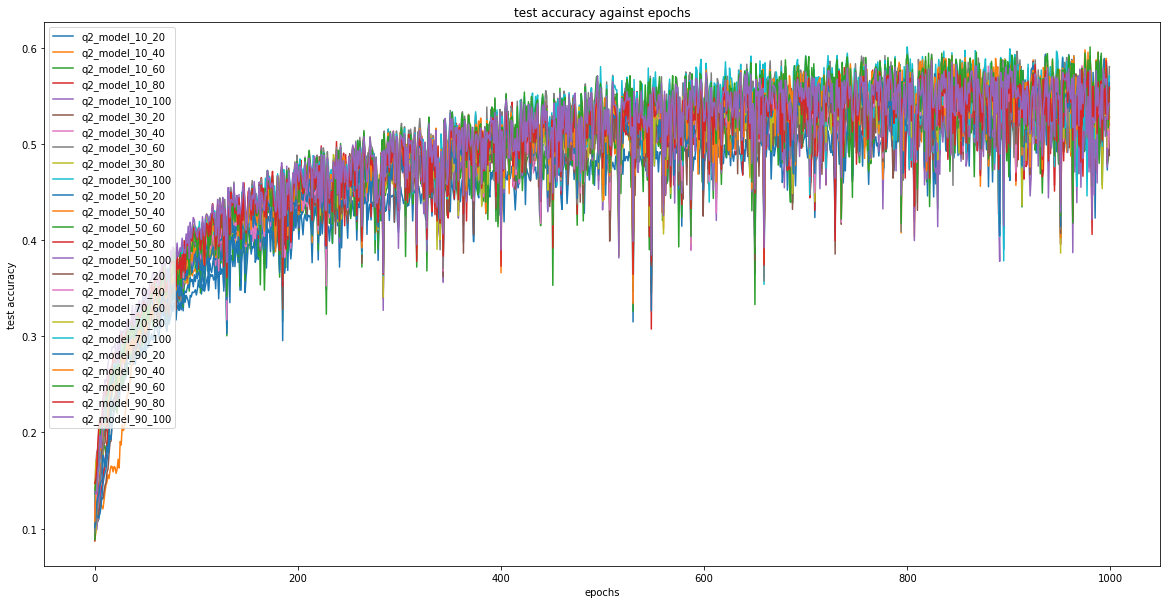

In [25]:
compare_test_acc(histories_json, 'q2_compare_test_acc')

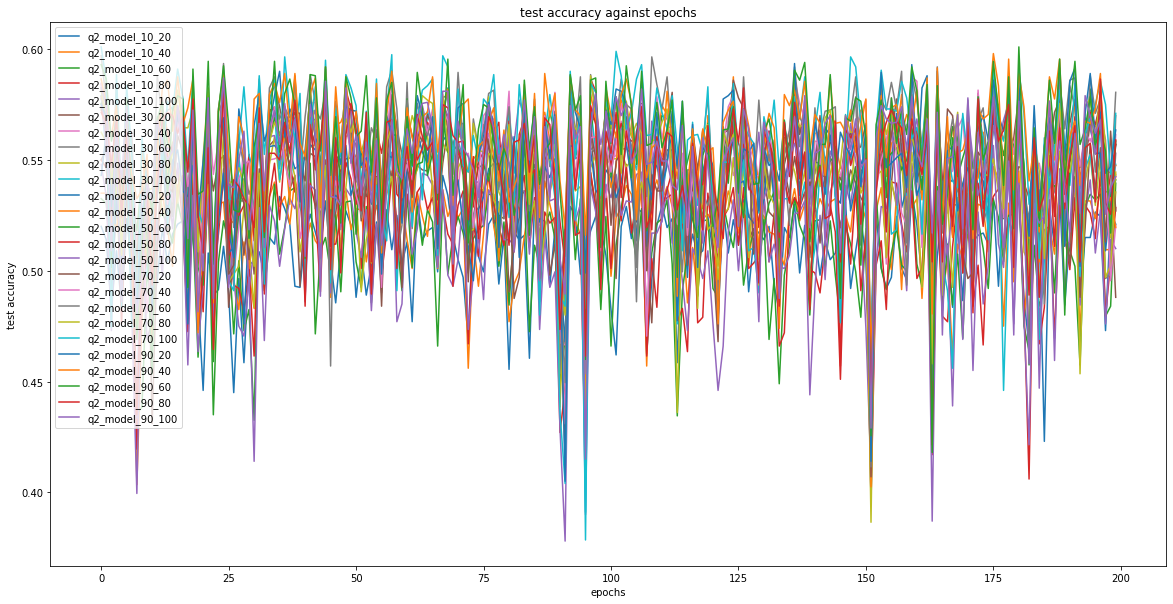

In [26]:
compare_test_acc(histories_json, 'q2_compare_test_acc_from_epoch_800', 800)

### Even the last 200 epochs have major fluctuations. Do an averaging over the last 200 and select the best average

In [27]:
ave_test_acc_from_epoch_800 = {}

for model_name in histories_json.keys():    
  test_acc = histories_json[model_name]['val_accuracy'][800:]
  ave_test_acc_from_epoch_800[model_name] = np.mean(test_acc)

ave_test_acc_from_epoch_800

{'q2_model_10_100': 0.5092549993097782,
 'q2_model_10_20': 0.5072299998998642,
 'q2_model_10_40': 0.5165350003540516,
 'q2_model_10_60': 0.5079275012016297,
 'q2_model_10_80': 0.5130325011909008,
 'q2_model_30_100': 0.5356725010275841,
 'q2_model_30_20': 0.5303774985671044,
 'q2_model_30_40': 0.5441125003993511,
 'q2_model_30_60': 0.5437750002741814,
 'q2_model_30_80': 0.5301324997842312,
 'q2_model_50_100': 0.5432974998652935,
 'q2_model_50_20': 0.5372199986875057,
 'q2_model_50_40': 0.5496200008690357,
 'q2_model_50_60': 0.5447699983417987,
 'q2_model_50_80': 0.5449249994754791,
 'q2_model_70_100': 0.5574675002694129,
 'q2_model_70_20': 0.5477649991214275,
 'q2_model_70_40': 0.548912497907877,
 'q2_model_70_60': 0.5547874991595745,
 'q2_model_70_80': 0.5480099998414516,
 'q2_model_90_100': 0.5468275010585785,
 'q2_model_90_20': 0.5526650014519692,
 'q2_model_90_40': 0.5589424978196621,
 'q2_model_90_60': 0.5553849995136261,
 'q2_model_90_80': 0.5434250001609325}

In [28]:
best = max(ave_test_acc_from_epoch_800, key=ave_test_acc_from_epoch_800.get)
print(best, ':', ave_test_acc_from_epoch_800[best])

q2_model_90_40 : 0.5589424978196621


### Just in case the crazy fluctuations affected our result, we try and prune it and see if there are changes

In [29]:
histories_json_pruned = {}

for model_name in histories_json.keys():    
  test_acc = histories_json[model_name]['val_accuracy'][800:]
  if np.max(test_acc) - np.min(test_acc) < 0.15:
    histories_json_pruned[model_name] = histories_json[model_name]

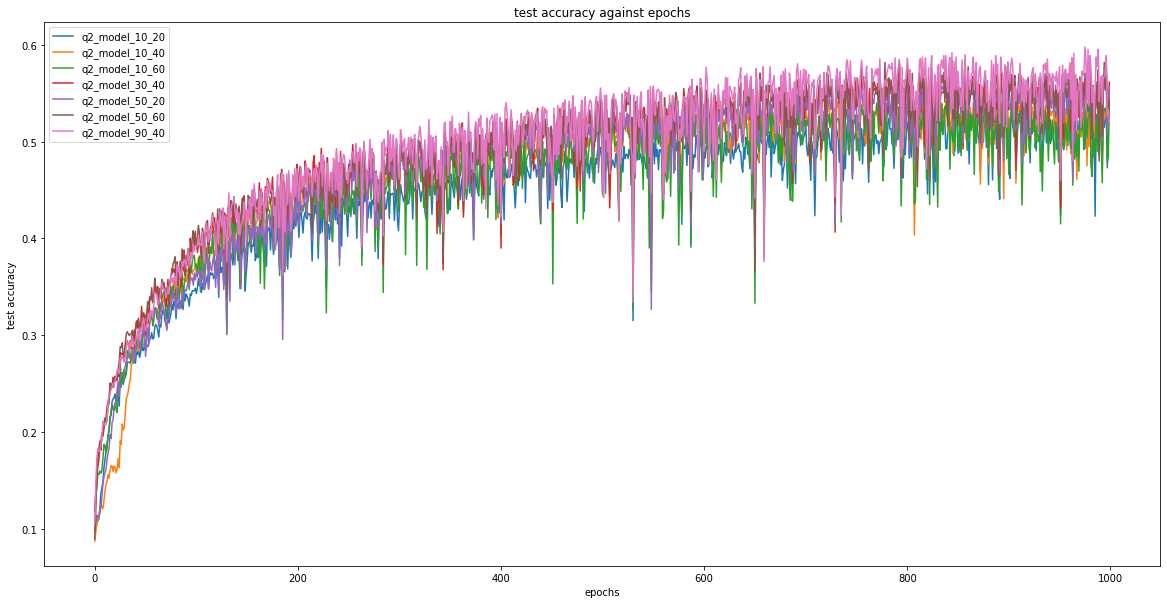

In [30]:
compare_test_acc(histories_json_pruned, 'q2_compare_test_acc_pruned')

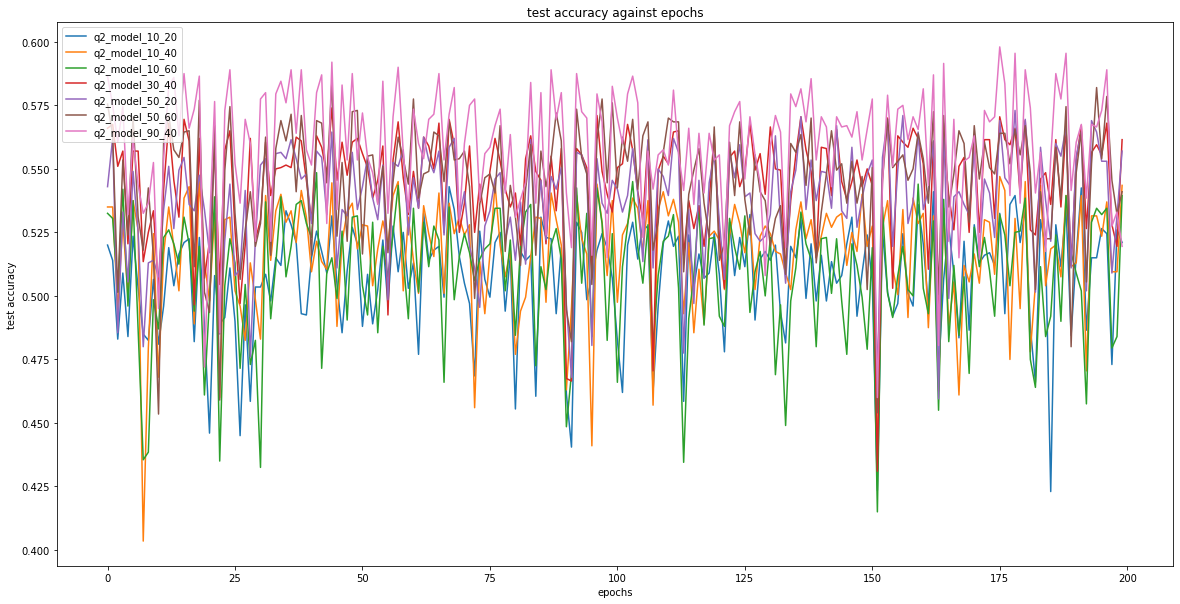

In [31]:
compare_test_acc(histories_json_pruned, 'q2_compare_test_acc_pruned_from_epoch_800', 800)

In [32]:
ave_test_acc_pruned_from_epoch_800 = {}

for model_name in histories_json_pruned.keys():    
  test_acc = histories_json_pruned[model_name]['val_accuracy'][800:]
  ave_test_acc_pruned_from_epoch_800[model_name] = np.mean(test_acc)

ave_test_acc_pruned_from_epoch_800

{'q2_model_10_20': 0.5072299998998642,
 'q2_model_10_40': 0.5165350003540516,
 'q2_model_10_60': 0.5079275012016297,
 'q2_model_30_40': 0.5441125003993511,
 'q2_model_50_20': 0.5372199986875057,
 'q2_model_50_60': 0.5447699983417987,
 'q2_model_90_40': 0.5589424978196621}

In [33]:
best_pruned = max(ave_test_acc_pruned_from_epoch_800, key=ave_test_acc_pruned_from_epoch_800.get)
print(best_pruned, ':', ave_test_acc_pruned_from_epoch_800[best_pruned])

q2_model_90_40 : 0.5589424978196621


# Conclusion - select q2_model_90_40 

It has the best with average test accuracy for last 200 epochs at 0.5589424978196621

It is the best with and without pruning off the models with large fluctuations, hence it is stable and has the best performance